## Is it a bird?

In [47]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [48]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

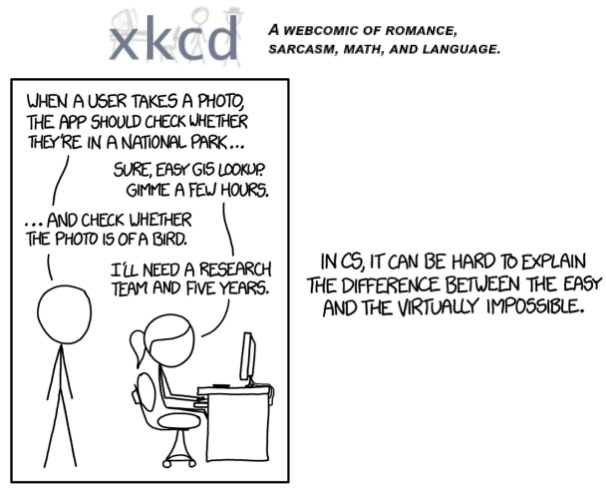

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [11]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [49]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=20): 
    return L(DDGS().images(keywords=term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [18]:
urls = search_images('bird photos', max_images=1)
urls[0]

/home/james/code/course22/notebookenv/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://images.alphacoders.com/492/492674.jpg'

...and then download a URL and take a look at it:

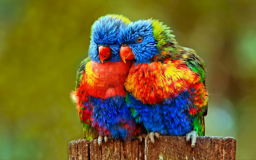

In [19]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

/home/james/code/course22/notebookenv/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


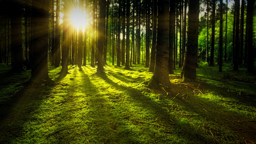

In [4]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "bird" and "forest" photos, and save each group of photos to a different folder:

In [35]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

NameError: name 'download_images' is not defined

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

16

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

/home/james/code/course22/notebookenv/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


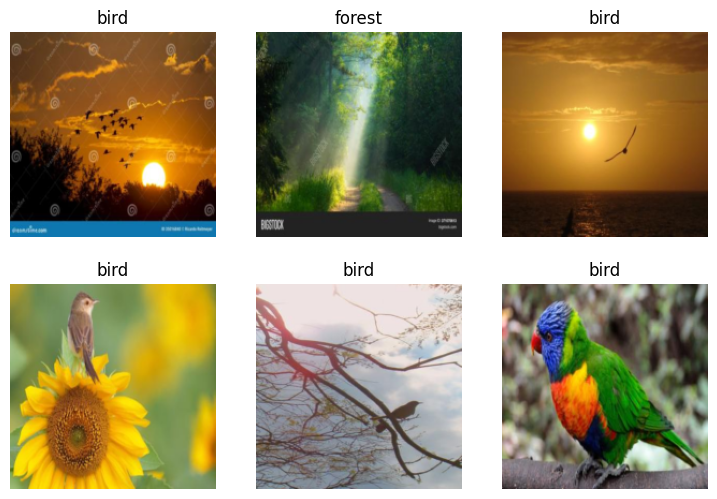

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/james/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 29.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.641050,0.228817,0.081633,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.091812,0.011730,0.000000,00:20
1,0.061295,0.011404,0.010204,00:20
2,0.041669,0.006093,0.000000,00:20


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [9]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9971


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

## Step 4: My model (Snowboarder vs skier vs surfer)

I am going to try to trin a model that finds skier vs a snowboarder

In [84]:
from fastdownload import download_url
from duckduckgo_search import DDGS
from fastcore.all import *
from fastai.vision.all import *


In [103]:
searches = 'snowboader','skier','surfer'
path = Path('snowboarder_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} riding close up', 100))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} riding photo', 100))
    resize_images(path/o, max_size=400, dest=path/o)


In [104]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

45

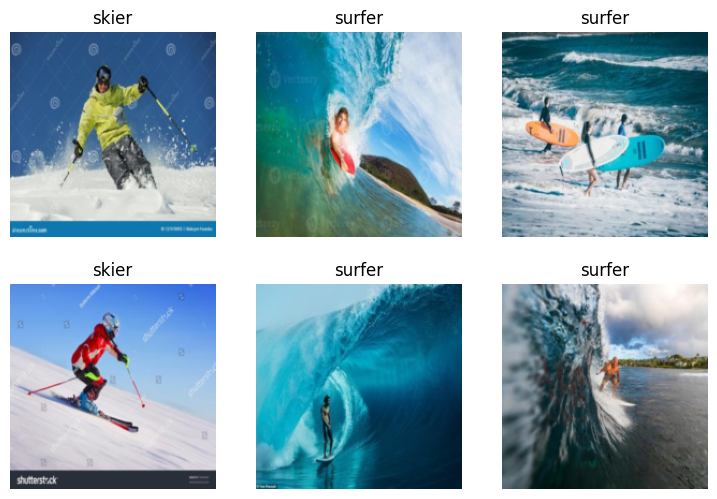

In [105]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [106]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch     train_loss  valid_loss  error_rate  time    
0         1.613449    0.732431    0.278846    00:16                                    
epoch     train_loss  valid_loss  error_rate  time    
0         0.748556    0.494684    0.182692    00:22                                    
1         0.498169    0.409947    0.163462    00:19                                    
2         0.342398    0.389260    0.153846    00:19                                    


### Now we will test our model

In [110]:
searches = 'snowboader','skier','surfer'
path = Path('snowboarder_or_not_validation')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} riding close up photo', 5))
    sleep(1) 
    download_images(dest, urls=search_images(f'{o} riding photo', 5))
    resize_images(path/o, max_size=400, dest=path/o)



In [111]:
path = Path('snowboarder_or_not_validation')
print(get_image_files(path))
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

[Path('snowboarder_or_not_validation/snowboader/f06e3497-ae73-4fde-9fa9-0aa994bfb803.jpg'), Path('snowboarder_or_not_validation/snowboader/5df1f5f8-ad9b-4dff-8826-8d159cb79df7.jpg'), Path('snowboarder_or_not_validation/snowboader/c0cbeedb-4913-4898-94f6-87371de50c92.jpg'), Path('snowboarder_or_not_validation/snowboader/a6f5617d-0d82-45e6-a312-7e2f5b8adb2e.jpg'), Path('snowboarder_or_not_validation/snowboader/6a3f0abf-b335-458e-992c-2715d6923018.jpg'), Path('snowboarder_or_not_validation/snowboader/9d48954a-2bad-43a4-90ac-d1d2097031cf.jpg'), Path('snowboarder_or_not_validation/snowboader/945726ff-d196-450c-9661-700c5285512b.jpg'), Path('snowboarder_or_not_validation/snowboader/85334aac-91c5-4936-9398-68ef3f075071.jpg'), Path('snowboarder_or_not_validation/snowboader/7ce022bf-d678-41b7-9607-67a4521ba47c.jpg'), Path('snowboarder_or_not_validation/skier/3cdd5e84-e5bd-4921-beba-30dee10a812f.jpg'), Path('snowboarder_or_not_validation/skier/649504d4-34ae-4f65-b690-159241152840.jpg'), Path('sn

5

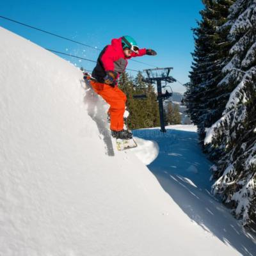

This is a: snowboader.                                               
Probability it's a snowboard: 0.9999
Probability it's a skier: 0.0001
Probability it's a surfer: 0.0000


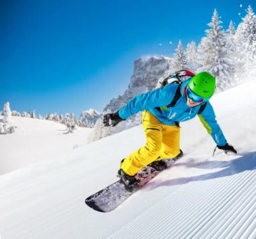

This is a: snowboader.                                               
Probability it's a snowboard: 0.9895
Probability it's a skier: 0.0102
Probability it's a surfer: 0.0003


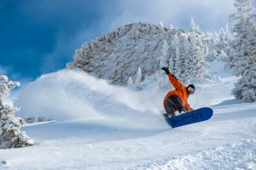

This is a: snowboader.                                               
Probability it's a snowboard: 0.9878
Probability it's a skier: 0.0121
Probability it's a surfer: 0.0001


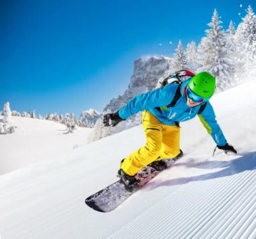

This is a: snowboader.                                               
Probability it's a snowboard: 0.9895
Probability it's a skier: 0.0102
Probability it's a surfer: 0.0003


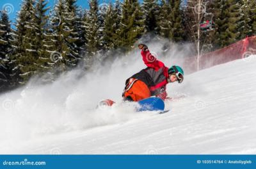

This is a: snowboader.                                               
Probability it's a snowboard: 0.9977
Probability it's a skier: 0.0023
Probability it's a surfer: 0.0000


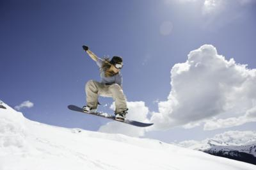

This is a: snowboader.                                               
Probability it's a snowboard: 0.9929
Probability it's a skier: 0.0071
Probability it's a surfer: 0.0000


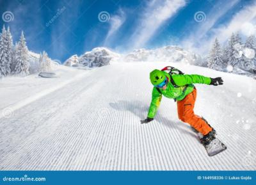

This is a: snowboader.                                               
Probability it's a snowboard: 0.9977
Probability it's a skier: 0.0006
Probability it's a surfer: 0.0017


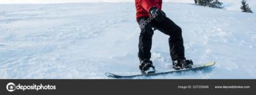

This is a: snowboader.                                               
Probability it's a snowboard: 0.9986
Probability it's a skier: 0.0014
Probability it's a surfer: 0.0000


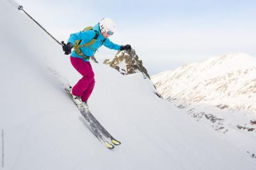

This is a: skier.                                                    
Probability it's a snowboard: 0.0003
Probability it's a skier: 0.9995
Probability it's a surfer: 0.0002


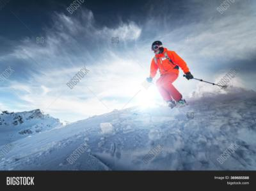

This is a: skier.                                                    
Probability it's a snowboard: 0.0108
Probability it's a skier: 0.9855
Probability it's a surfer: 0.0037


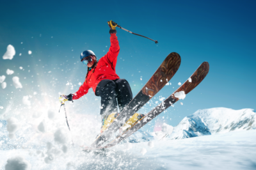

This is a: skier.                                                    
Probability it's a snowboard: 0.0002
Probability it's a skier: 0.9996
Probability it's a surfer: 0.0002


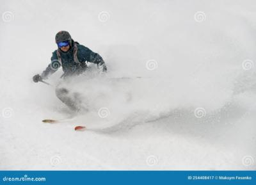

This is a: snowboader.                                               
Probability it's a snowboard: 0.8364
Probability it's a skier: 0.1460
Probability it's a surfer: 0.0176


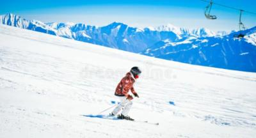

This is a: skier.                                                    
Probability it's a snowboard: 0.0066
Probability it's a skier: 0.9933
Probability it's a surfer: 0.0001


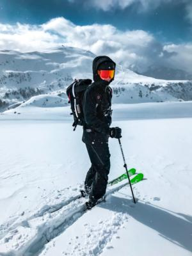

This is a: skier.                                                    
Probability it's a snowboard: 0.0005
Probability it's a skier: 0.9995
Probability it's a surfer: 0.0000


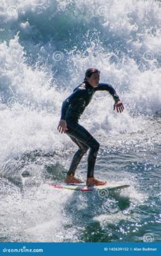

This is a: surfer.                                                   
Probability it's a snowboard: 0.0000
Probability it's a skier: 0.0001
Probability it's a surfer: 0.9999


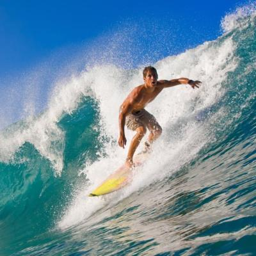

This is a: surfer.                                                   
Probability it's a snowboard: 0.0000
Probability it's a skier: 0.0000
Probability it's a surfer: 1.0000


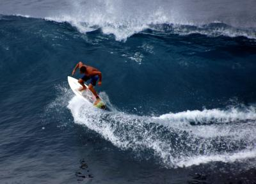

This is a: surfer.                                                   
Probability it's a snowboard: 0.0000
Probability it's a skier: 0.0000
Probability it's a surfer: 1.0000


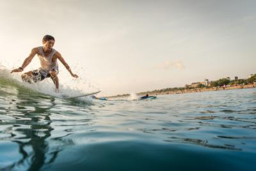

This is a: surfer.                                                   
Probability it's a snowboard: 0.0000
Probability it's a skier: 0.0000
Probability it's a surfer: 0.9999


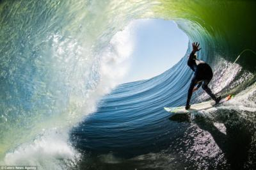

This is a: surfer.                                                   
Probability it's a snowboard: 0.0002
Probability it's a skier: 0.0006
Probability it's a surfer: 0.9992


In [112]:
from IPython.display import display
path = Path('snowboarder_or_not_validation')
for image_path in get_image_files(path):
    display(Image.open(image_path).to_thumb(256,256))
    is_snowboard,_,probs = learn.predict(PILImage.create(image_path))
    print(f"This is a: {is_snowboard}.")
    print(f"Probability it's a snowboard: {probs[1]:.4f}")
    print(f"Probability it's a skier: {probs[0]:.4f}")
    print(f"Probability it's a surfer: {probs[2]:.4f}")
    